In [15]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [16]:
path = "./archive/stemmed_cleaned_data.csv"

df = pd.read_csv(path, delimiter=",", quotechar='"')

print(df.head())

                              title  \
0               Mental Note Vol. 24   
1         Your Brain On Coronavirus   
2                    Mind Your Nose   
3          The 4 Purposes of Dreams   
4  Surviving a Rod Through the Head   

                                                text  \
0  Photo by Josh Riemer on Unsplash\n\nMerry Chri...   
1  Your Brain On Coronavirus\n\nA guide to the cu...   
2  Mind Your Nose\n\nHow smell training can chang...   
3  Passionate about the synergy between science a...   
4  You’ve heard of him, haven’t you? Phineas Gage...   

                                                 url                 authors  \
0  https://medium.com/invisible-illness/mental-no...            ['Ryan Fan']   
1  https://medium.com/age-of-awareness/how-the-pa...       ['Simon Spichak']   
2  https://medium.com/neodotlife/mind-your-nose-f...                      []   
3  https://medium.com/science-for-real/the-4-purp...  ['Eshan Samaranayake']   
4  https://medium.com/live-y

In [17]:
# Prétraitement : Suppression des NaN et Transformation TF-IDF
tags = [
    "Blockchain", "Data Science", "Technology", "Programming", "Poetry",
    "Cryptocurrency", "Machine Learning", "Life", "Bitcoin", "Writing",
    "Politics", "Startup", "Life Lessons", "Self Improvement", "Covid 19",
    "Software Development", "Love", "Python", "Business", "Health",
    "Mental Health", "JavaScript", "Relationships", "Education",
    "Artificial Intelligence", "Culture", "Design", "Self", "Marketing",
    "Entrepreneurship", "Ethereum", "Music", "Productivity",
    "Web Development", "History", "Humor", "Data Visualization",
    "Leadership", "Social Media", "Psychology", "Travel", "Fiction",
    "Creativity", "Coronavirus", "Parenting", "Crypto", "Science",
    "Tech", "UX", "Short Story"
]

tag_groups = {
    "Blockchain": "Crypto",
    "Bitcoin": "Crypto",
    "Cryptocurrency": "Crypto",
    "Ethereum": "Crypto",
    "Tech": "Technology",
    "Programming": "Technology",
    "Software Development": "Technology",
    "Python": "Technology",
    "JavaScript": "Technology",
    "Web Development": "Technology",
    "Data Science": "AI & Data",
    "Machine Learning": "AI & Data",
    "Artificial Intelligence": "AI & Data",
    "Data Visualization": "AI & Data",
    "Startup": "Business",
    "Entrepreneurship": "Business",
    "Marketing": "Business",
    "Business": "Business",
    "Health": "Wellness",
    "Mental Health": "Wellness",
    "Self Improvement": "Wellness",
    "Life Lessons": "Wellness",
}

# Liste des 20 premiers tags
top_20_tags = tags[:20].copy()

#On ne garde que les article qui possent un des 20 tags séléctionnés

df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Filtrer le DataFrame pour ne garder que les articles avec ces tags
df = df[df['tags'].apply(lambda tags: any(tag in top_20_tags for tag in tags))].copy()

# On ne garde que le premier tag pour chaque article
df['main_tag'] = df['tags'].apply(lambda tags: next((tag for tag in tags if tag in top_20_tags), None))

# Appliquer les regroupements
df['main_tag'] = df['main_tag'].apply(lambda x: tag_groups.get(x, x))

# Supprime les lignes avec clean_text vide
df = df.dropna(subset=['clean_text'])  

print(df)

#tf-idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['clean_text'])

                                                    title  \
0                                     Mental Note Vol. 24   
3                                The 4 Purposes of Dreams   
4                        Surviving a Rod Through the Head   
5       Mentally, Young Adults Are Suffering Most From...   
6       How to Turn Your Popular Blog Series Into a Be...   
...                                                   ...   
192333  [Live Stream] 2021 Soul Train Music Awards | F...   
192336  The global startup festival “COMEUP 2021” begi...   
192340  How To Deal with Loneliness in Festivals & Exp...   
192342                        Type 2 Diabetes on the Rise   
192343  The Concept of Stem Cells. Have you ever wonde...   

                                                     text  \
0       Photo by Josh Riemer on Unsplash\n\nMerry Chri...   
3       Passionate about the synergy between science a...   
4       You’ve heard of him, haven’t you? Phineas Gage...   
5       Mentally, Young

In [18]:
#Réduction de Dimension avec LDA (LDA nécessite y catégorique)
y = df['main_tag'].astype('category').cat.codes  # Encodage des classes
lda = LDA(n_components=min(len(np.unique(y))-1, 19))  # LDA limité à nb_classes-1
X_lda = lda.fit_transform(X_tfidf.toarray(), y)

In [19]:
# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

# Définition des classificateurs et de leurs hyperparamètres
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

params = {
    "KNN": {'n_neighbors': [5, 10, 20, 50, 100, 500, 1000, 10000]},
    "Decision Tree": {'max_depth': [5, 10, 20, 50]},
    "SVM": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, 50]}
}


🔍 Optimisation et test du modèle : KNN
✨ Meilleurs paramètres : {'n_neighbors': 100}
📊 Meilleure précision: 0.7609
              precision    recall  f1-score   support

   AI & Data       0.78      0.85      0.81      1724
    Business       0.74      0.70      0.72      1393
    Covid 19       0.69      0.73      0.71       687
      Crypto       0.92      0.94      0.93      2213
        Life       0.49      0.33      0.40       677
        Love       0.59      0.56      0.57       527
      Poetry       0.67      0.82      0.74      1037
    Politics       0.82      0.86      0.84       943
  Technology       0.81      0.75      0.78      2913
    Wellness       0.68      0.71      0.69      1962
     Writing       0.73      0.69      0.71       854

    accuracy                           0.76     14930
   macro avg       0.72      0.72      0.72     14930
weighted avg       0.76      0.76      0.76     14930



<Figure size 1200x1000 with 0 Axes>

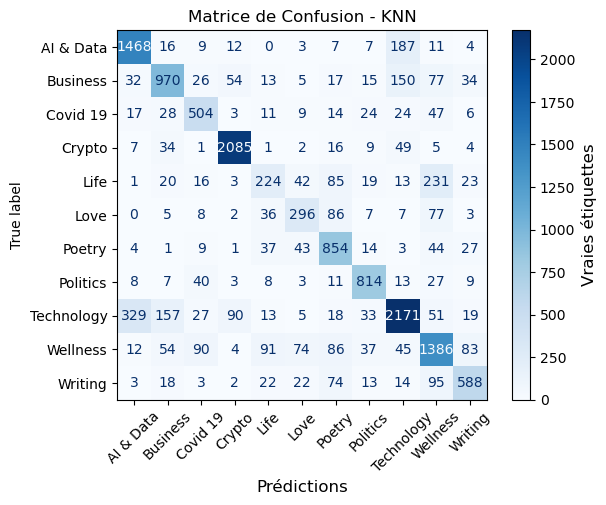


🔍 Optimisation et test du modèle : Decision Tree
✨ Meilleurs paramètres : {'max_depth': 10}
📊 Meilleure précision: 0.7359
              precision    recall  f1-score   support

   AI & Data       0.77      0.83      0.80      1724
    Business       0.67      0.70      0.69      1393
    Covid 19       0.64      0.67      0.65       687
      Crypto       0.90      0.93      0.91      2213
        Life       0.44      0.37      0.41       677
        Love       0.61      0.44      0.51       527
      Poetry       0.62      0.82      0.71      1037
    Politics       0.85      0.81      0.83       943
  Technology       0.81      0.72      0.76      2913
    Wellness       0.63      0.67      0.65      1962
     Writing       0.76      0.63      0.69       854

    accuracy                           0.74     14930
   macro avg       0.70      0.69      0.69     14930
weighted avg       0.74      0.74      0.73     14930



<Figure size 1200x1000 with 0 Axes>

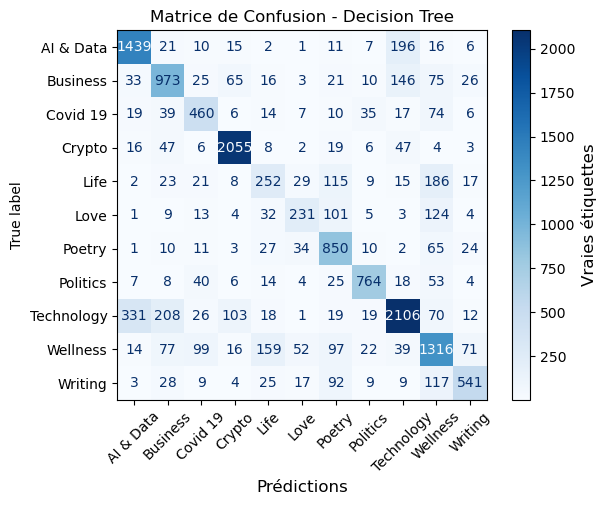


🔍 Optimisation et test du modèle : SVM
✨ Meilleurs paramètres : {'C': 1, 'kernel': 'rbf'}
📊 Meilleure précision: 0.7620
              precision    recall  f1-score   support

   AI & Data       0.77      0.86      0.82      1724
    Business       0.73      0.70      0.71      1393
    Covid 19       0.67      0.76      0.71       687
      Crypto       0.92      0.95      0.93      2213
        Life       0.51      0.30      0.38       677
        Love       0.59      0.53      0.56       527
      Poetry       0.68      0.83      0.74      1037
    Politics       0.82      0.86      0.84       943
  Technology       0.82      0.74      0.78      2913
    Wellness       0.68      0.71      0.69      1962
     Writing       0.72      0.71      0.72       854

    accuracy                           0.76     14930
   macro avg       0.72      0.72      0.72     14930
weighted avg       0.76      0.76      0.76     14930



<Figure size 1200x1000 with 0 Axes>

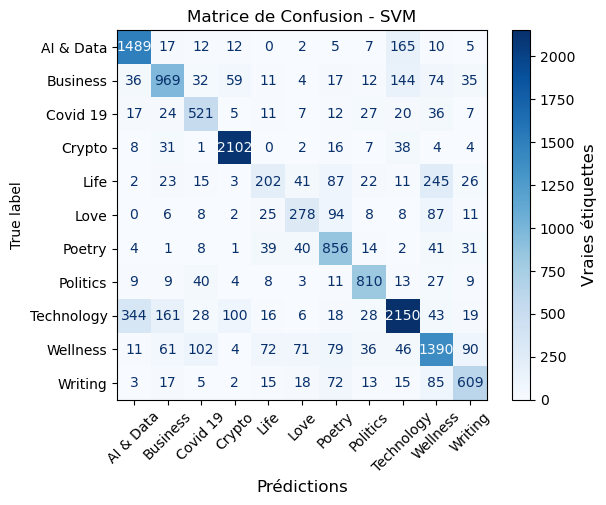


🔍 Optimisation et test du modèle : Random Forest
✨ Meilleurs paramètres : {'max_depth': 20, 'n_estimators': 200}
📊 Meilleure précision: 0.7621
              precision    recall  f1-score   support

   AI & Data       0.78      0.85      0.82      1724
    Business       0.73      0.70      0.71      1393
    Covid 19       0.68      0.74      0.71       687
      Crypto       0.92      0.95      0.93      2213
        Life       0.49      0.35      0.41       677
        Love       0.60      0.53      0.56       527
      Poetry       0.68      0.82      0.74      1037
    Politics       0.84      0.86      0.85       943
  Technology       0.81      0.75      0.78      2913
    Wellness       0.68      0.70      0.69      1962
     Writing       0.73      0.70      0.71       854

    accuracy                           0.76     14930
   macro avg       0.72      0.72      0.72     14930
weighted avg       0.76      0.76      0.76     14930



<Figure size 1200x1000 with 0 Axes>

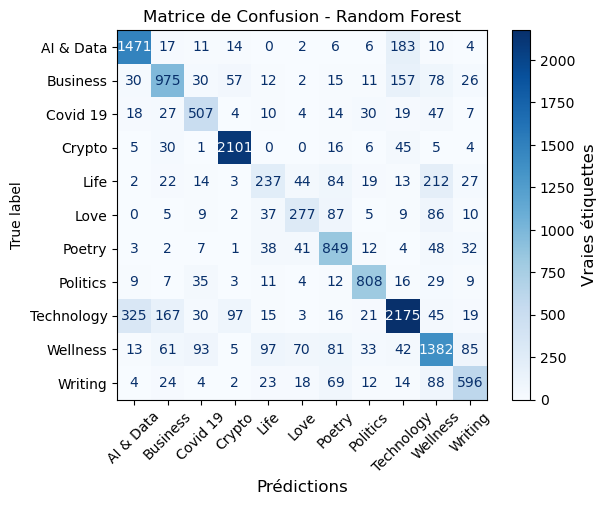

In [20]:
# Mapping des indices de classes aux tags
tag_mapping = dict(enumerate(df['main_tag'].astype('category').cat.categories))

# Entraînement et évaluation des modèles
results = {}

for model_name, model in models.items():
    print(f"\n🔍 Optimisation et test du modèle : {model_name}")
    
    # Optimisation des hyperparamètres si applicable
    if params[model_name]:
        grid = GridSearchCV(model, params[model_name], cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"✨ Meilleurs paramètres : {grid.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_model = model

    # Prédictions et évaluation
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[model_name] = acc
    
    print(f"📊 Meilleure précision: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=[tag_mapping[i] for i in np.unique(y_test)]))
    
    # Matrice de confusion avec labels des tags
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[tag_mapping[i] for i in np.unique(y_test)])
    
    plt.figure(figsize=(12, 10))  # Augmenter la taille
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[tag_mapping[i] for i in np.unique(y_test)])
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.gcf().axes[0].set_xlabel("Prédictions", fontsize=12)
    plt.gcf().axes[1].set_ylabel("Vraies étiquettes", fontsize=12)
    plt.show()

In [21]:
# Affichage des résultats globaux
print("\nRésumé des précisions obtenues :")
for model, score in results.items():
    print(f"{model}: {score:.4f}")



Résumé des précisions obtenues :
KNN: 0.7609
Decision Tree: 0.7359
SVM: 0.7620
Random Forest: 0.7621
